In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn
import scipy.stats as stats
import seaborn as sns
import datetime 
import statsmodels

<a id='section1'></a>
# Is the Outlook Sunny for Solar Companies?

A time-series analysis of select US-based companies within the solar energy market.


### Table of Contents

[1. Introduction](#section2)<br>
[2. Getting the Data](#section3)<br>
[3. Exploratory Analysis:](#section4)<br>
* [Long-Term Performance](#section5)<br>
* [Relationship to Market](#section6)<br>
* [Relationship to Crude Oil](#section7)<br>
* [Exploratory Conclusions](#section8)<br>

[4. Seasonal Decomposition](#section9)<br>
[5. Model Preparation](#section10)<br>
[6. Stationarity Tests](#section11)<br>
[7. ARIMA:](#section12)<br>
* [ACF/PACF Plots](#section13)<br>
* [Model Configuration](#section14)<br>
* [RUN Model](#section15)<br>
* [SPWR Model](#section16)<br>

[8. Prophet:](#section17)<br>
* [RUN Model](#section18)<br>
* [SPWR Model](#section19)<br>

[9. Summary](#section23)<br>

<a id='section2'></a>
## 1. Introduction

In this notebook, we'll conduct a time-series analysis of stock prices for select companies within the solar industry.  The main research goal is the following:
* __Can the stock price of each company be predicted with reasonable accuracy?  Based on what we learn, does investing in solar look promising?__

Additionally, I'll explore the relationship of the stock price fluctuations to the overall market, as well as to the price of crude oil to see if there's any sort of feedback going on between conventional/renewable energy metrics.  

Motivation for the project came from a general interest in renewable energy and the desire to invest in companies pushing the renewable energy market in the US.  This notebook focuses specifically on solar stocks, but the principles could be extended to other types of renewable energy.  

Two companies were chosen for analysis; Sunrun Inc. and Sunpower.  

__Sunrun__ (ticker = SUN) is a San Francisco, CA based company focusing on residential solar electricity.  The company went public in August 2015 and is traded on the NASDAQ.

__Sunpower__ (ticker = SPWR) is a San Jose, CA based company providing solar electricity solutions for residential and commercial applications, as well as solar power plants (i.e. solar farms).  The company went public in November 2005 and is traded on the NASDAQ.

In addition to real-world applications, this project is my first deep-dive into time series analysis and forecasting and has proven to be a tremendous learning experience.  I also built an interactive Tableau dashboard that you can check out here:

https://public.tableau.com/profile/missy.tracy#!/vizhome/SolarInvestingDashboard/Dashboard1

The notebook is quite long so I've provided navigation links for easier maneuvering.  A the end of each major section, you'll have the option to come back up to the Table of Contents.

Enjoy!

<a id='section3'></a>
## 2. Getting the Data

Let's start by getting the data.  Stock data is easily obtained from the NASDAQ website: https://www.nasdaq.com/.  The website provides daily data from the last 10-years.  SPWR has been publicly traded since 2005, so we can extract the full 10-years worth of data points.  RUN has only been publicly traded since 2015, so our data set will be much smaller.  

To answer the question of the relationship of stock prices to the overall market, I'll be using the S&P 500 as a proxy.  This information is also available on https://www.nasdaq.com/.

Daily crude oil prices were obtained from: http://www.macrotrends.net/1369/crude-oil-price-history-chart

We start by importing the data and doing some light manipulation.  Luckily, the data comes in an easy to use format and doesn't require much wrangling.

In [9]:
# Crude oil prices
oil = pd.read_csv('oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
oil = oil.rename(columns={'value': 'oil'})

# S&P 500 data
sp = pd.read_csv('sp500.csv')
sp['date'] = pd.to_datetime(sp['date'])
sp = sp.rename(columns={' value': 'sp500'})

# RUN data
run = pd.read_csv('run.csv')
run = run.drop(index=0, columns=['volume', 'open', 'high', 'low'])
run['date'] = pd.to_datetime(run['date'])
run = run.rename(columns={'close': 'run'})

# SPWR data
spwr = pd.read_csv('spwr.csv')
spwr = spwr.drop(index=0, columns=['volume', 'open', 'high', 'low'])
spwr['date'] = pd.to_datetime(spwr['date'])
spwr = spwr.rename(columns={'close': 'spwr'})

# String together merge operations, joining on the date.
# Do left join with RUN data since the date range is less than the other 3 variables
df = oil.merge(spwr, on='date', how='inner').merge(sp, on='date', how='inner')
df = df.merge(run, on='date', how='left')

# Set date time index, drop original date column
df.set_index(pd.DatetimeIndex(df.date), inplace=True)
df.drop(columns=['date'], inplace=True)
print(df.head(), '\n', df.tail())


               oil   spwr    sp500  run
date                                   
2008-05-16  126.50  93.50  1425.35  NaN
2008-05-19  127.15  89.62  1426.63  NaN
2008-05-20  128.93  88.37  1413.40  NaN
2008-05-21  132.99  85.33  1390.71  NaN
2008-05-22  130.04  82.64  1394.35  NaN 
               oil  spwr    sp500    run
date                                   
2018-05-07  70.73  8.42  2672.63   9.33
2018-05-08  69.06  8.47  2671.92   9.43
2018-05-09  71.14  9.01  2697.79   9.83
2018-05-10  71.36  9.01  2723.07  11.50
2018-05-11  70.70  8.71  2727.72  10.69


In [10]:
# Evaluate number of data points
print('# RUN data points:',len(df.run.dropna()))
print('# SPWR data points:',len(df.spwr.dropna()))

# RUN data points: 698
# SPWR data points: 2513


As expected, the number of data points for RUN is much smaller than SPWR.  This will allow us to compare the performance of analysis/forecasting techniques on different sized data sets to see if it makes a difference.  Given the volatility and uncertainty of stock trading, 698 points is still provides quite a bit of information.  

[return to top](#section1)

<a id='section4'></a>
## 3. Exploratory Analysis

Now let's dive into some exploratory analysis.  Goals for this section are the following:

1. Long-term performance of the individual variables and comparison of stocks to one another. 
2. Relationship of stock prices to overall market 
3. Relationship of stock prices to crude oil

<a id='section5'></a>
### Long-Term Performance

Let's start by plotting up a time-series for each variable to get a feel for general behavior.

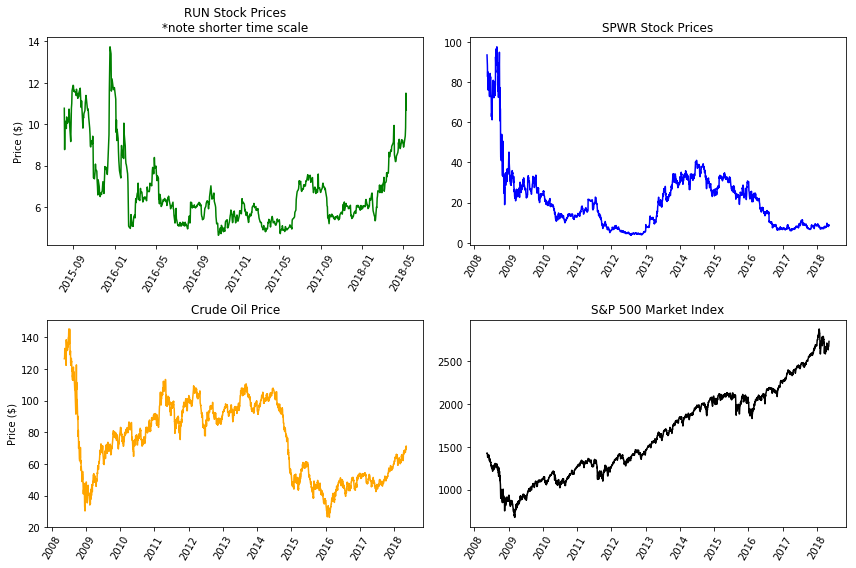

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.plot(df.index, df.run, color='green')
plt.ylabel('Price ($)')
plt.title('RUN Stock Prices\n*note shorter time scale')
plt.xticks(rotation=60)

plt.subplot(222)
plt.plot(df.index, df.spwr, color='blue')
plt.title('SPWR Stock Prices')
plt.xticks(rotation=60)

plt.subplot(223)
plt.plot(df.index, df.oil, color='orange')
plt.ylabel('Price ($)')
plt.title('Crude Oil Price')
plt.xticks(rotation=60)

plt.subplot(224)
plt.plot(df.index, df.sp500, color='black')
plt.title('S&P 500 Market Index')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

We can clearly see that prices for both stocks and crude oil are highly volatile.  There are no apparent long-term trends.  RUN stocks appear to be rising sharply in 2018.  Crude oil prices are also on the rise.  

SPWR was hit hard by the 2008-2009 financial crisis and hasn't really recovered. There was a resurgence in prices between 2013 and 2015, but prices again dropped by the beginning of 2017.  Perhaps this has something to do with the current Administration and government attitudes towards climate change.  That's a topic that could warrant a whole notebook of it's own.  We'll leave it as pure speculation for now.

The overall market also shows volatility, but illustrates an overall increasing trend.

Let's take a closer look at the two solar companies and see how they stack up to one another.

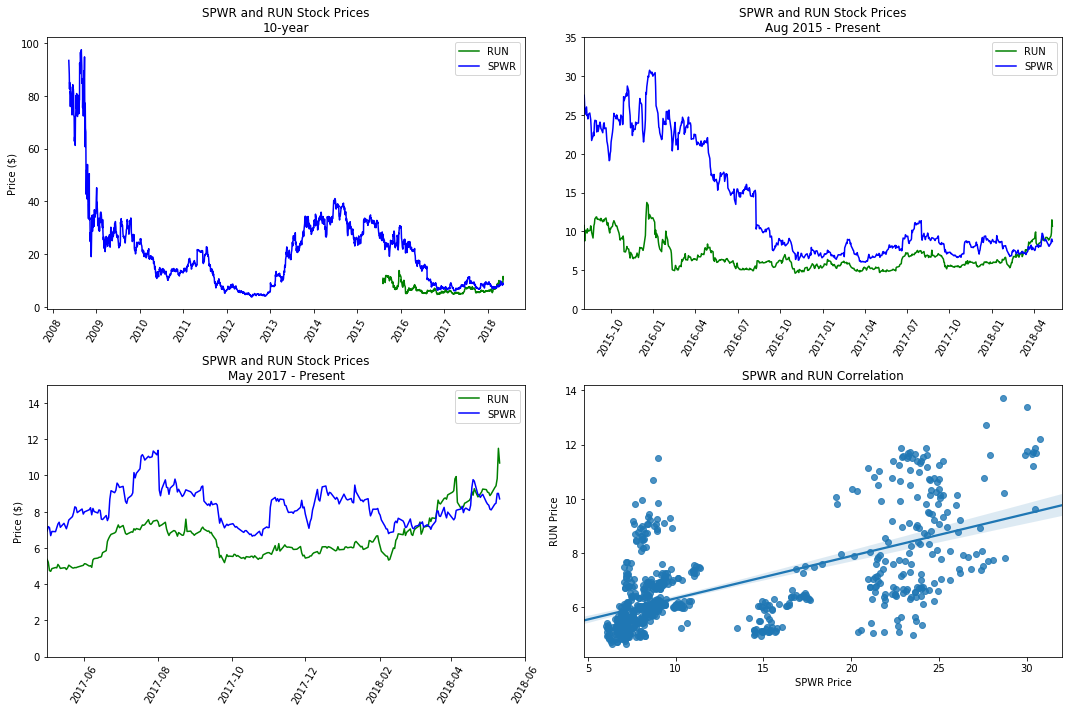


SPWR/RUN Regression: LinregressResult(slope=0.15626381898647587, intercept=4.757073343223398, rvalue=0.622902911360103, pvalue=2.9688846459697986e-76, stderr=0.007438858758955954)


In [79]:
# Compare RUN and SPWR

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(df.index, df.run, label='RUN', color='green')
plt.plot(df.index, df.spwr, label='SPWR', color='blue')
plt.title('SPWR and RUN Stock Prices\n10-year')
plt.ylabel('Price ($)')
plt.xticks(rotation=60)
plt.legend()

plt.subplot(222)
plt.plot(df.index, df.run, label='RUN', color='green')
plt.plot(df.index, df.spwr, label='SPWR', color='blue')
plt.title('SPWR and RUN Stock Prices\nAug 2015 - Present')
plt.xlim([datetime.date(2015, 8, 5), datetime.date(2018, 6, 1)])
plt.ylim(0, 35)
plt.xticks(rotation=60)
plt.legend()

plt.subplot(223)
plt.plot(df.index, df.run, label='RUN', color='green')
plt.plot(df.index, df.spwr, label='SPWR', color='blue')
plt.title('SPWR and RUN Stock Prices\nMay 2017 - Present')
plt.ylabel('Price ($)')
plt.xlim([datetime.date(2017, 5, 1), datetime.date(2018, 6, 1)])
plt.ylim(0, 15)
plt.xticks(rotation=60)
plt.legend()

plt.subplot(224)
sns.regplot(df.spwr, df.run)
plt.title('SPWR and RUN Correlation')
plt.xlabel('SPWR Price')
plt.ylabel('RUN Price')

plt.tight_layout()
plt.show()

print('\nSPWR/RUN Regression:', stats.linregress(df.spwr[len(df.spwr)-len(df.run.dropna()):], df.run.dropna()))

We see that SPWR started out at a much higher share price than RUN, but they've both been at about the same price since late 2016.  Looking at values from the past year, we see that RUN prices have been on the rise and recently surpassed SPWR.  The prices are positively correlated, with an r-squaured value of 0.62.  This likely follows general price trends in the solar sector as a whole.  


<a id='section6'></a>
### Relationship to Market

Now let's take a look at the relationship of stock and oil prices to the market.  From our previous graphs above, it doesn't look like the prices of either stocks or oil follow any larger patterns observed in the market.  But just to be sure, let's make some regression plots and see what we get.

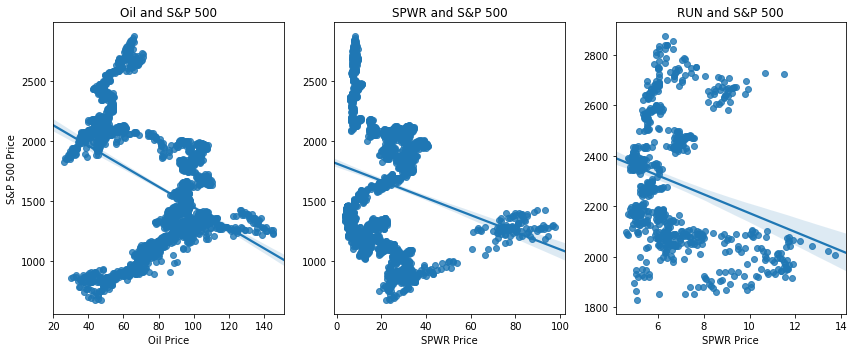


S&P500/SPWR Regression: LinregressResult(slope=-0.006460014012702894, intercept=31.769147424270436, rvalue=-0.21463804640305112, pvalue=1.4126178959678278e-27, stderr=0.0005866266196385048)

S&P500/RUN Regression: LinregressResult(slope=-0.0018490660768315703, intercept=11.038141192786558, rvalue=-0.26287215760562344, pvalue=1.7009412277741617e-12, stderr=0.0002572493721406282)

S&P500/Oil Regression: LinregressResult(slope=-0.01830363502068996, intercept=105.37268152077161, rvalue=-0.39481489678236137, pvalue=1.6065095829377044e-94, stderr=0.0008500077067265044)


In [155]:
# Market correlations

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
sns.regplot(df.oil, df.sp500)
plt.title('Oil and S&P 500')
plt.ylabel('S&P 500 Price')
plt.xlabel('Oil Price')

plt.subplot(1,3,2)
sns.regplot(df.spwr, df.sp500)
plt.title('SPWR and S&P 500')
plt.xlabel('SPWR Price')
plt.ylabel('')

plt.subplot(1,3,3)
sns.regplot(df.run, df.sp500)
plt.title('RUN and S&P 500')
plt.xlabel('SPWR Price')
plt.ylabel('')

plt.tight_layout()
plt.show()

print('\nS&P500/SPWR Regression:', stats.linregress(df.sp500, df.spwr))
print('\nS&P500/RUN Regression:', stats.linregress(df.sp500[len(df.sp500)-len(df.run.dropna()):], df.run.dropna()))
print('\nS&P500/Oil Regression:', stats.linregress(df.sp500, df.oil))

Yikes, those are some funky looking regression plots!  They're not telling us a whole lot other than the prices are all over the place.  Regression analysis indicates the prices of oil and both stocks are actually negatively correlated with the overall market.  So as the market does worse, stock prices rise?  That doesn't make a whole lot of sense.  It's more likely we're simply seeing noise/volatility in these plots and not any meaningful relationships.

<a id='section7'></a>
### Relationship to Crude Oil Price

Now let's look a little deeper into the relationship between crude oil prices and stock prices.  I'd expect that as oil prices rise, there'd be more interest in renewable energy as a whole.  Does this appear to be the case for our two solar companies? 

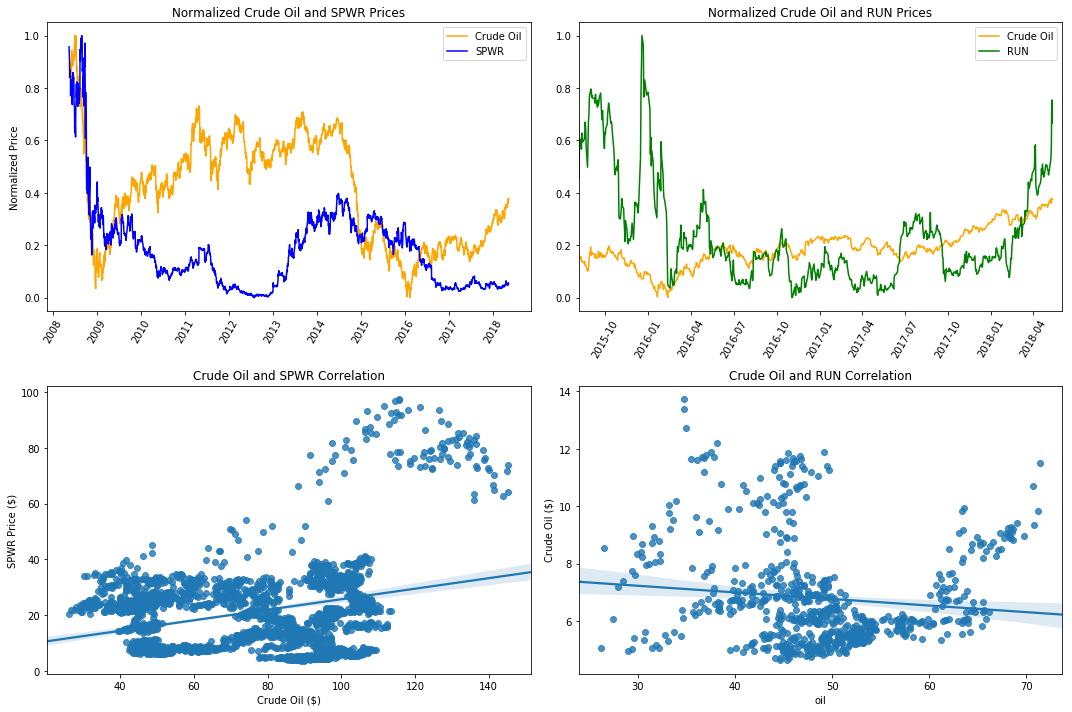

Oil/SPWR Regression: LinregressResult(slope=0.18848987744435064, intercept=6.903137964822546, rvalue=0.2903388119475267, pvalue=5.252675124136731e-50, stderr=0.01239758194573966)

Oil/RUN Regression: LinregressResult(slope=-0.02296227761050459, intercept=7.919444220411496, rvalue=-0.10938074085899187, pvalue=0.003812033494872775, stderr=0.007909623928218359)


In [82]:
# Scale to unit prices for better visual comparison since oil/stock price scales are different
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

oil_ = df.oil
oil_ = oil_.values.reshape((len(oil_), 1))
oil_norm = scaler.fit_transform(oil_)

run_ = df.run.dropna()
run_ = run_.values.reshape((len(run_), 1))
run_norm = scaler.fit_transform(run_)

spwr_ = df.spwr
spwr_ = spwr_.values.reshape((len(spwr_), 1))
spwr_norm = scaler.fit_transform(spwr_)


# Customize subplot layout
plt.figure(figsize=(15, 10))

# Crude oil/SPWR
plt.subplot(221)
plt.plot(df.index, oil_norm, label='Crude Oil', color='orange')
plt.plot(df.index, spwr_norm, label='SPWR', color='blue')
plt.title('Normalized Crude Oil and SPWR Prices')
plt.ylabel('Normalized Price')
plt.xticks(rotation=60)
plt.legend()

# Crude oil/RUN
plt.subplot(222)
plt.plot(df.index[len(oil_norm) - len(run_norm):], oil_norm[len(oil_norm) - len(run_norm):], label='Crude Oil', color='orange')
plt.plot(df.index[len(oil_norm) - len(run_norm):], run_norm, label='RUN', color='green')
plt.title('Normalized Crude Oil and RUN Prices')
plt.xticks(rotation=60)
plt.xlim([datetime.date(2015, 8, 5), datetime.date(2018, 6, 1)])
plt.legend()

# Crude oil/SPWR regression
plt.subplot(223)
sns.regplot(df.oil, df.spwr)
plt.title('Crude Oil and SPWR Correlation')
plt.xlabel('Crude Oil ($)')
plt.ylabel('SPWR Price ($)')

# Crude oil/RUN regression
plt.subplot(224)
sns.regplot(df.oil, df.run)
plt.title('Crude Oil and RUN Correlation')
plt.ylabel('Crude Oil ($)')

plt.tight_layout()
plt.show()

# Get regression coefficients for various interactions
print('Oil/SPWR Regression:', stats.linregress(df.oil, df.spwr))
print('\nOil/RUN Regression:', stats.linregress(df.oil[len(df.oil)-len(df.run.dropna()):], df.run.dropna()))

Well, that's not what I was expecting to see.  It looks like the price of SPWR actually goes down as oil prices rise.  The opposite is true for RUN.  I think what we're seeing here is that our stock prices aren't related to oil prices.  Perhaps there'd be a clearer connection if we were looking at electric cars or fuel efficiency.   


<a id='section8'></a>
### Exploratory Takeaways

Here's a recap of what we learned:

* Overall trends
    * Stock and crude oil prices show a lot more volatility than the overall market
* Stock comparisons
    * SPWR prices have dropped considerably in the last decade and are now in the same general vicinity as RUN.  RUN stocks have been on the rise and recently surpassed SPWR.  
    * The prices of RUN and SPWR are positively correlated with an r-squared of 0.62.  This is likely indicative of correlation between each stock and the overall solar/renewable energy market sector and not any sort of interaction between the actual companies.
* No correlation between stocks and overall market performance  
* No correlation between stocks and crude oil prices
    
[return to top](#section1)

<a id='section9'></a>
## 4. Seasonal Decomposition
 
Now that we have a feel for our data, let's dig a little deeper and do some time-series decomposition.  Time-series data is made up of systematic and non-systematic components.  Systematic components can be modeled and include:  
* Trend: direction of overall change
* Seasonality: repeating cycles over a shorter period of time

Non-systematic components come from error and randomness in the data and can't be modeled.

StatsModels has a seasonal_decompose() function that provides a naive decomposition using either an additive (linear) or multiplicative (non-linear) model.  Based on our initial data exploration, there's not much apparent structure and we definitely don't observe any multiplicative behavior, so we'll decompose the data using an additive model.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


RUN Weekly


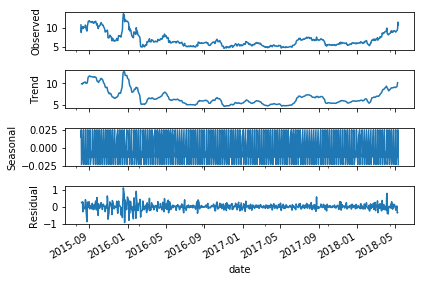

RUN Yearly


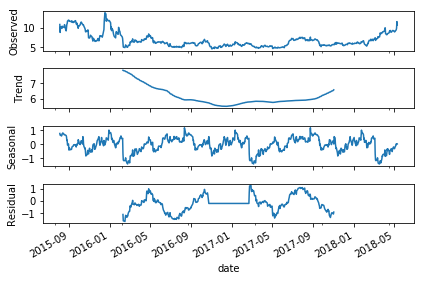

In [89]:
# RUN Weekly 
print('RUN Weekly')
run_decompose = seasonal_decompose(df.run.dropna(), model='additive', freq=(5)) # 5trading days/week
run_decompose.plot()
plt.show()

# RUN Yearly 
print('RUN Yearly')
run_decompose = seasonal_decompose(df.run.dropna(), model='additive', freq=(5*52)) #5 trading days/week, 52 weeks/year
run_decompose.plot()
plt.show()

SPWR Weekly


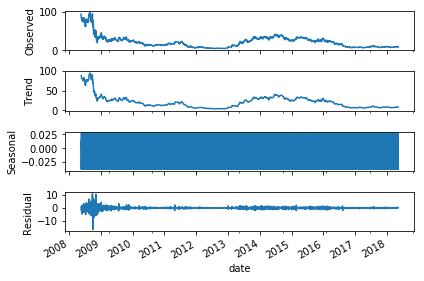

SPWR Yearly


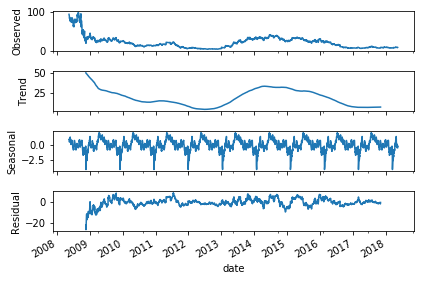

In [90]:
# SPWR Weekly 
print('SPWR Weekly')
spwr_decompose = seasonal_decompose(df.spwr.dropna(), model='additive', freq=(5)) #5 trading days/week
spwr_decompose.plot()
plt.show()

# SPWR Yearly 
print('SPWR Yearly')
run_decompose = seasonal_decompose(df.spwr.dropna(), model='additive', freq=(5*52)) #5 trading days/week, 52 weeks per year
run_decompose.plot()
plt.show()

None of the data appears to have any trend or seasonality to it.  Weekly patterns mimic the daily data, and yearly patterns for SPWR are smoothed averages of daily values for SPWR.   RUN doesn't have enough data for yearly trends.  What we're seeing is a lot of noise.  This may prove to be quite problematic for modeling efforts because there isn't any structure for the model to grab onto.  

[return to top](#section1)

<a id='section10'></a>
## 5. Model Preparation

Let's start our modeling journey with creating training and testing data.  Unlike traditional supervised learning models where we randomly split the data, our training and testing data sets needs to remain sequential to preserve time dependency.  We'll experiment with two different sizes of test data, taking the last 30 and 90 days of stock prices.  

In [11]:
# 30 day history
run_train30 = df.run[:-30].dropna()
run_test30 = df.run[-30:]
print('RUN train:', len(run_train30), 
      '\nRUN test:', len(run_test30), 
      '\nFraction of total data set:', len(run_test30)/len(run.dropna()))

spwr_train30 = df.spwr[:-30]
spwr_test30 = df.spwr[-30:]
print('\nSPWR train:', len(spwr_train30), 
      '\nSPWR test:', len(spwr_test30),
     '\nFraction of total data set:', len(spwr_test30)/len(spwr.dropna()))

RUN train: 668 
RUN test: 30 
Fraction of total data set: 0.04297994269340974

SPWR train: 2483 
SPWR test: 30 
Fraction of total data set: 0.011918951132300357


In [12]:
# 90 day history
run_train90 = df.run[:-90].dropna()
run_test90 = df.run[-90:]
print('RUN train:', len(run_train90), 
      '\nRUN test:', len(run_test90), 
      '\nFraction of total data set:', len(run_test90)/len(run.dropna()))

spwr_train90 = df.spwr[:-90]
spwr_test90 = df.spwr[-90:]
print('\nSPWR train:', len(spwr_train90), 
      '\nSPWR test:', len(spwr_test90),
     '\nFraction of total data set:', len(spwr_test90)/len(spwr.dropna()))

RUN train: 608 
RUN test: 90 
Fraction of total data set: 0.12893982808022922

SPWR train: 2423 
SPWR test: 90 
Fraction of total data set: 0.03575685339690107


[return to top](#section1)

<a id='section11'></a>
## 6. Stationarity Tests

Before we model, it's important to test for stationarity.  Stationarity tests a data set for mean and variance stability through time.  If the mean and variance are not time dependent, the data is stationary.  

The Augmented Dickey-Fuller (ADF) test is a formal statistical test for stationarity.  The null hypothesis assumes non-stationarity.  If p < 0.05, we reject the null and assume the alternate hypothesis of stationarity.  If p > 0.05, we accept the null of non-stationarity.

A non-stationary data set can be made stationary by differencing.  

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
# Write function to teste for stationarity
def stationarity_test(name, x):
    result = adfuller(x)
    print(name,':')
    print('ADF Statistic %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print('{} data set is NOT stationary, differencing required!\n'.format(name))
    else:
        print('{} is stationary, hooray!\n'.format(name))

In [21]:
stationarity_test('RUN 30', run_train30)
stationarity_test('SPWR 30', spwr_train30)

RUN 30 :
ADF Statistic -2.910445
p-value: 0.044147
RUN 30 is stationary, hooray!

SPWR 30 :
ADF Statistic -4.020752
p-value: 0.001306
SPWR 30 is stationary, hooray!



In [22]:
stationarity_test('RUN 90', run_train90)
stationarity_test('SPWR 90', spwr_train90)

RUN 90 :
ADF Statistic -2.859578
p-value: 0.050254
RUN 90 data set is NOT stationary, differencing required!

SPWR 90 :
ADF Statistic -4.001842
p-value: 0.001401
SPWR 90 is stationary, hooray!



The results of the ADF tests indicate all but one of our training data sets is stationary.  This is an interesting finding and likely another indicator of the large degree of randomness in our data.  As a test, we will apply differencing to the data sets in the ARIMA models below to see if it makes a difference in the model outcomes. 

[return to top](#section1)

<a id='section12'></a>
## 7. ARIMA

An autoregressive integrated moving average (ARIMA) model is a fundamental technique in time-series analysis.  It is made up of three components:
* Autoregressive (AR*p*): Number of lag terms to build a simple linear model on.  Looks at *p* past values.
* Integrated (I*d*): Degree of differencing needed to make the data stationary.  
* Moving Average (MA*q*): Number of lag terms to look at for moving average.  Looks at error terms from *q* past values.

<a id='section13'></a>
### ACF/PACF Plots

Autoregressive correlation plots (ACF) and partial autoregressive correlation plots (PACF) are useful visual tools for estimating the AR(p) and MA(q) parameters. ACF plots show correlations between a series and its lags, providing estimates for MA(q). PACF plots show correlations between a value and error from previous lags, providing estimates for AR(p).

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [24]:
def autocorrelation_model(name, x):
    plot_acf(pd.Series(x), lags=50, alpha=.05)
    plt.title('{} - Autocorrelation Function'.format(name))
    plt.show()

    plot_pacf(pd.Series(x), lags=50, alpha=0.05)
    plt.title('{} - Partial Autocorrelation Function'.format(name))
    plt.show()

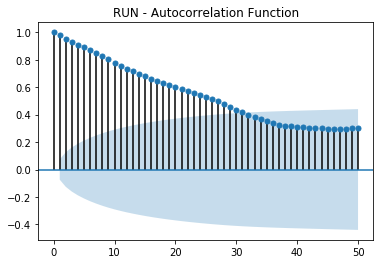

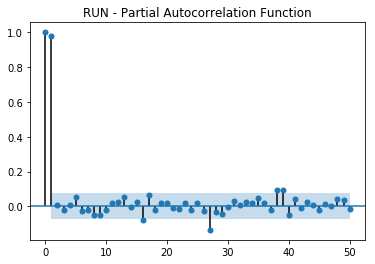

In [25]:
# ACF/PACF for RUN
autocorrelation_model('RUN', df.run.dropna())

For RUN, the ACF shows high correlation for a lag period of up to 30 days.  The PACF shows strong correlation only for a lag period of 1 day.  95% confidence intervals are plotted.

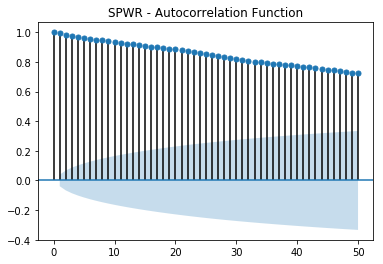

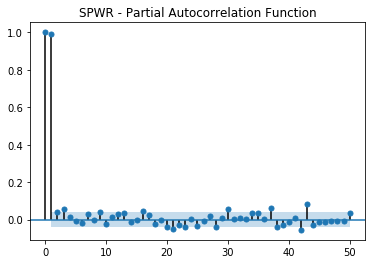

In [26]:
# ACF/PACF for SPWR
autocorrelation_model('SPWR', df.spwr)

For SPWR, the ACF shows high correlation for a lag period well beyond the 50 day cutoff shown. The PACF shows strong correlation only for a lag period of 1 day.  Again, 95% confidence intervals are shown.

From these plots, we can obtain reasonable starting parameters and then build up a grid search to find the best combination.

Grid search starting point:
* AR(p) = [1]
* I(d) = [0, 1]
* MA(q) = range(10)

<a id='section14'></a>
### Model Configurations

Next we'll build some functions to fit and test various ARIMA configurations to determine the best model for the data.  Typically, we'd look to the Akaike information criteria (AIC) to evalute a model, choosing the model configuration with the lowest AIC score.  However, getting AIC values over a rather expansive grid seach takes a lot of work and involves manually reading model output tables.  To automate this process, we'll instead use each model configuration to make predictions and test those predictions against known values.  This allows us to select a model configuration that miminizes mean squared error. Predictions are made in a forward walk process in which the previously predicted value is used to predict the next value, stepping through predictions one day at a time.

We'll also build functions to examine residuals from the optimized model configuration.  Examining the residuals in an ARIMA model is an important step because the model is based on a linear regression and the underlying assumptions of a linear regression.  Ideally, we want to see that our error terms are random and normally distributed. 

In [27]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Function to generate predictions for a given arima order
def evaluate_arima(train, test, arima_order):
    # Populate history based on training set
    history = [x for x in train]
    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Use rolling forward walk predictions.  Fit model using history,
    # adding each prediction to history to continue forecasting
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        # Get prediction
        y_pred = model_fit.forecast()[0]
        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
    
    error = mean_squared_error(test, predictions)
    return error

# Function to determine best arima order combination based on lowest MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
                try:
                    mse = evaluate_arima(train, test, arima_order)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    print('ARIMA config: {}; MSE:{}'.format(arima_order, mse))
                except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
                    pass
    
    print('Best ARIMA config:', best_config)
    print('MSE:', best_score)

# Function to evaluate residuals
def plot_residuals(name, train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('{}: {},{},{} Residuals'.format(name, p, d, q))
    residuals.plot()
    
    plt.subplot(1,2,2)
    residuals.hist(bins=25)
    plt.title('{} Residual Histogram'.format(name))
    plt.show()

# Function to plot predictions
def plot_predictions(name, train, test, p, d, q):
    
    arima_order = (p,d,q)
    
    history = [x for x in train]
    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Recreate evaluate_arima model.  Need to do this instead of calling existing model
    # to return predictions list
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        # Get prediction
        y_pred = model_fit.forecast()[0]
        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
     
    # Plots
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{} Prediction Validation: - Full Time Series'.format(name))
    plt.ylabel('Price ($)')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{} Prediction Validation - 2018'.format(name))
    plt.ylabel('Price ($)')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 6, 1)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()

<a id='section15'></a>
### RUN Models

Let's use our functions on the RUN stock data to determine the best model configuration using both the 30-day and 90-day testing data sets.  

In [25]:
# Fit and test RUN ARIMA model- 30 day test period
arima_gridsearch(run_train30, run_test30, range(3), range(2), range(0, 11, 2))

ARIMA config: (0, 0, 0); MSE:6.396473275334917
ARIMA config: (0, 0, 2); MSE:6.070439630760343
ARIMA config: (0, 0, 4); MSE:5.739538119711451
ARIMA config: (0, 0, 6); MSE:5.440911729321038
ARIMA config: (0, 0, 8); MSE:5.232980123005033
ARIMA config: (0, 0, 10); MSE:5.052318301126101
ARIMA config: (0, 1, 0); MSE:0.5495855655272354
ARIMA config: (0, 1, 2); MSE:0.5425930445343998
ARIMA config: (0, 1, 4); MSE:0.5572949502843467
ARIMA config: (0, 1, 6); MSE:0.5488807860782042
ARIMA config: (0, 1, 8); MSE:0.5071949888614767
ARIMA config: (0, 1, 10); MSE:0.5630463171013843
ARIMA config: (1, 0, 0); MSE:0.8378280569544168
ARIMA config: (1, 0, 2); MSE:0.945424191720726
ARIMA config: (1, 0, 4); MSE:0.9131312931270847
ARIMA config: (1, 0, 6); MSE:0.9578740895432862
ARIMA config: (1, 0, 8); MSE:1.1088504699632316
ARIMA config: (1, 0, 10); MSE:1.0556430514510151
ARIMA config: (1, 1, 0); MSE:0.5450812541824438
ARIMA config: (2, 0, 0); MSE:0.8911193352647435
ARIMA config: (2, 0, 2); MSE:0.9478061934417

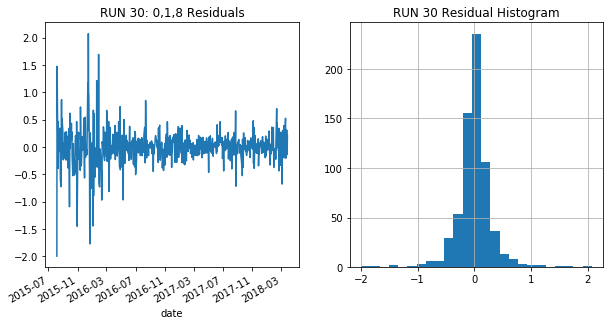

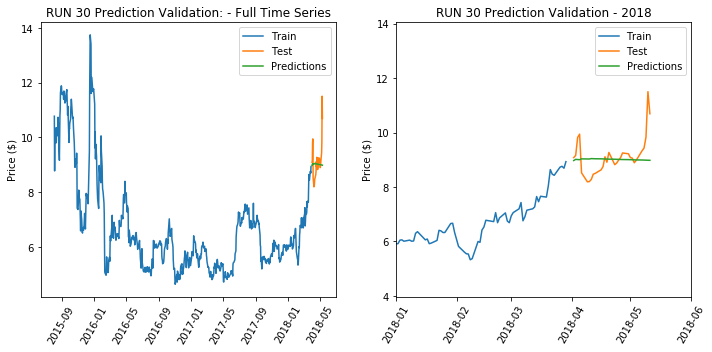

In [28]:
plot_residuals('RUN 30', run_train30, 0, 1, 8)
plot_predictions('RUN 30', run_train30, run_test30, 0, 1, 8)

In [27]:
# Fit and test RUN ARIMA model - 90 day test period
arima_gridsearch(run_train90, run_test90, range(3), range(2), range(0, 11, 2))

ARIMA config: (0, 0, 0); MSE:2.701114698123787
ARIMA config: (0, 0, 2); MSE:2.677523213031734
ARIMA config: (0, 0, 4); MSE:2.65376013963503
ARIMA config: (0, 0, 6); MSE:2.6328885287169803
ARIMA config: (0, 0, 8); MSE:2.6239356940262755
ARIMA config: (0, 0, 10); MSE:2.6049607483288315
ARIMA config: (0, 1, 0); MSE:6.515424693257733
ARIMA config: (0, 1, 2); MSE:6.608047346474705
ARIMA config: (0, 1, 4); MSE:6.6120395429982635
ARIMA config: (0, 1, 6); MSE:6.62279600817648
ARIMA config: (0, 1, 8); MSE:6.766649975280281
ARIMA config: (0, 1, 10); MSE:6.648921651581522
ARIMA config: (1, 0, 0); MSE:2.831793007078401
ARIMA config: (1, 0, 2); MSE:2.695182339964694
ARIMA config: (1, 0, 4); MSE:2.7673139108442735
ARIMA config: (1, 0, 6); MSE:2.727162386610617
ARIMA config: (1, 0, 8); MSE:2.571105185966798
ARIMA config: (1, 0, 10); MSE:2.5953689673943403
ARIMA config: (1, 1, 0); MSE:6.559854618909705
ARIMA config: (2, 0, 0); MSE:2.741721750386134
ARIMA config: (2, 1, 0); MSE:6.5959881225560215
Best 

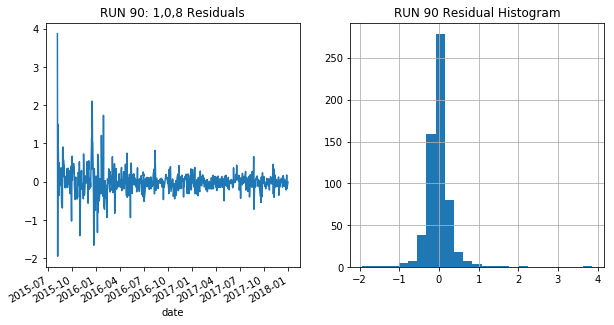

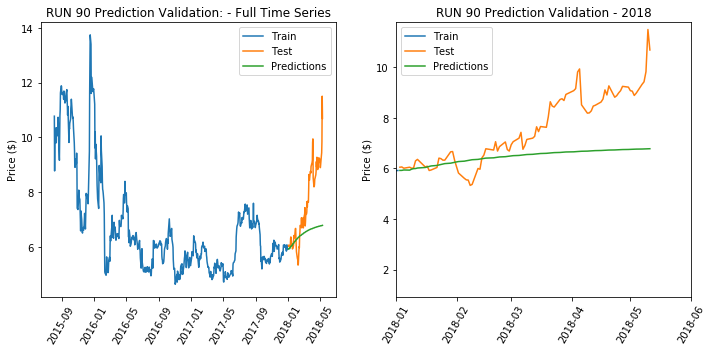

In [28]:
plot_residuals('RUN 90', run_train90, 1, 0, 8)
plot_predictions('RUN 90', run_train90, run_test90, 1, 0, 8)

RUN model results:
* 30 day predictions had a MSE = 0.50.  Residual analysis looks pretty good, showing larger residuals in the first year but otherwise random and evenly distributed.  Prediction is effectively a flat line.
* 90 day predictions had a MSE = 2.57.  Similar residual analysis as observed in 30-day test set. Predictions show slight increasing trend but is biased low.
* Neither model performed well against actual observations.

<a id='section16'></a>
### SPWR Models

Let's repeat the process for SPWR data and see if it does any better. 

In [29]:
# Fit and test SPWR ARIMA model - 30 day test period
arima_gridsearch(spwr_train30, spwr_test30, range(3), range(2), range(0, 10, 2))

ARIMA config: (0, 0, 0); MSE:161.38011875387164
ARIMA config: (0, 0, 2); MSE:154.02302719748468
ARIMA config: (0, 0, 4); MSE:148.83785194209534
ARIMA config: (0, 1, 0); MSE:1.6342378771462838
ARIMA config: (0, 1, 2); MSE:1.683375386091741
ARIMA config: (0, 1, 4); MSE:1.6648066641833197
ARIMA config: (0, 1, 6); MSE:1.6733627982168509
ARIMA config: (0, 1, 8); MSE:1.6373339204465318
ARIMA config: (1, 0, 0); MSE:0.2339036282526451
ARIMA config: (1, 0, 2); MSE:0.27799006780619456
ARIMA config: (1, 0, 4); MSE:0.25470989331044186
ARIMA config: (1, 0, 6); MSE:0.26583678995114907
ARIMA config: (1, 0, 8); MSE:0.255476583396446
ARIMA config: (1, 1, 0); MSE:1.6581237651543146
ARIMA config: (1, 1, 2); MSE:1.6868919682255974
ARIMA config: (1, 1, 4); MSE:1.6657984274236433
ARIMA config: (2, 0, 0); MSE:0.24074947513918804
ARIMA config: (2, 0, 2); MSE:0.27651727475759
ARIMA config: (2, 0, 4); MSE:0.2550836838991872
ARIMA config: (2, 1, 0); MSE:1.684243565594809
ARIMA config: (2, 1, 2); MSE:1.6289866569

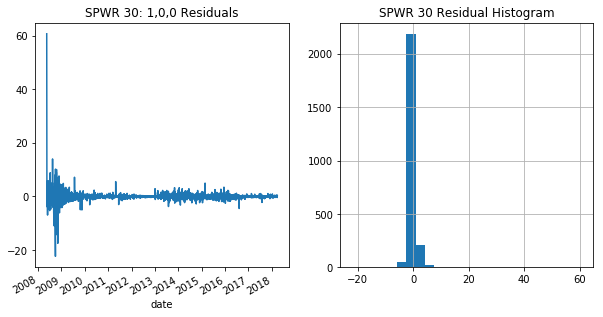

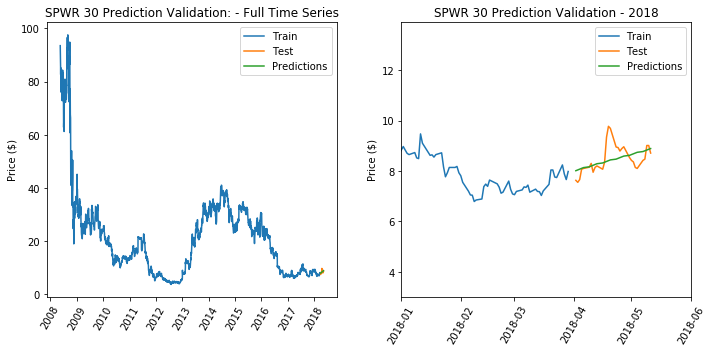

In [30]:
plot_residuals('SPWR 30', spwr_train30, 1, 0, 0)
plot_predictions('SPWR 30', spwr_train30, spwr_test30, 1, 0, 0)

In [31]:
# Fit and test SPWR ARIMA model - 90 day test period
arima_gridsearch(spwr_train90, spwr_test90, range(3), range(2), range(0, 10, 2))

ARIMA config: (0, 0, 0); MSE:183.00178798316952
ARIMA config: (0, 0, 2); MSE:181.5026589277695
ARIMA config: (0, 0, 4); MSE:180.42920000411507
ARIMA config: (0, 1, 0); MSE:1.9524397367136086
ARIMA config: (0, 1, 2); MSE:1.992039799114087
ARIMA config: (0, 1, 4); MSE:1.9967744720064158
ARIMA config: (0, 1, 6); MSE:1.982592960700586
ARIMA config: (0, 1, 8); MSE:1.9966419571665828
ARIMA config: (1, 0, 0); MSE:6.300201374371335
ARIMA config: (1, 0, 2); MSE:4.195669996210218
ARIMA config: (1, 0, 4); MSE:4.948347746075656
ARIMA config: (1, 0, 6); MSE:4.523290492336644
ARIMA config: (1, 0, 8); MSE:4.722046608455163
ARIMA config: (1, 1, 0); MSE:1.972481900857367
ARIMA config: (1, 1, 2); MSE:1.993479953154176
ARIMA config: (1, 1, 4); MSE:1.996502040283242
ARIMA config: (2, 0, 0); MSE:5.6380136913190455
ARIMA config: (2, 0, 2); MSE:4.255512589894541
ARIMA config: (2, 0, 4); MSE:4.9349964100227215
ARIMA config: (2, 1, 0); MSE:1.9956778381966342
Best ARIMA config: (0, 1, 0)
MSE: 1.9524397367136086

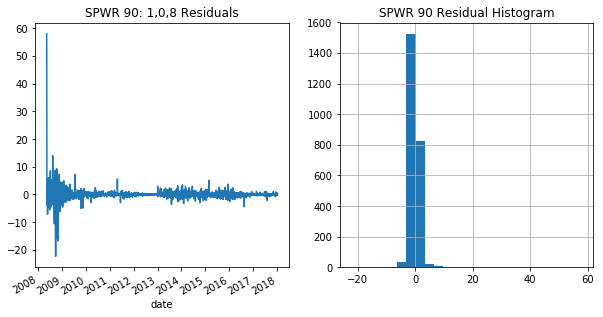

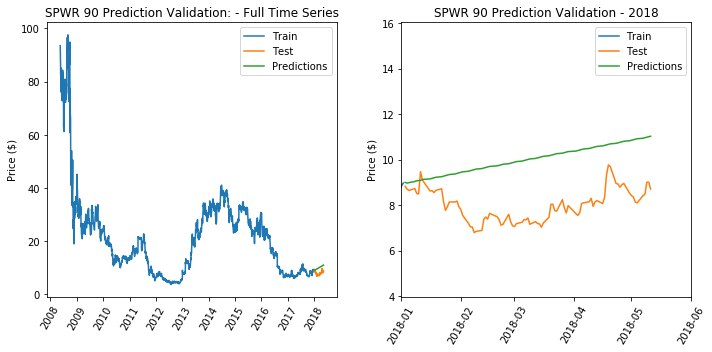

In [32]:
plot_residuals('SPWR 90', spwr_train90, 1, 0, 8)
plot_predictions('SPWR 90', spwr_train90, spwr_test90, 1, 0, 8)

SPWR model results:
* 30 day predictions had a MSE = 0.23.  Residual analysis looks pretty good except for a large degree of error during the 2008-2009 financial crisis.  Predictions show a linearly increasing trend that captures the data fairly well.
* 90 day predictions had a MSE = 1.95.  Similar residual analysis as observed in 30-day test set. Predictions show a linearly increasing trend but is biased high.


Overall, ARIMA performed better (but not great) for the SPWR data.  In both test cases, the 30-day predictions had a smaller MSE than the longer 90-day prediction window.  For our next model, we'll only look at the 30-day prediction window.

[return to top](#section1)

<a id='section17'></a>
## 8. Prophet

Prophet is a more sophisticaed open-source forecasting package developed by Facebook Research.

https://research.fb.com/prophet-forecasting-at-scale/

According to their website, it is an additive model with four main components:
* Piecewise linear or logistic growth curve.  Automatically detects changes in trends by selecting changepoints from the data.
* Yearly seasonal component modeled using Fourier series
* Weekly seasonal component using dummy variables
* User-provided list of important holidays

The package is user-friendly and aims to make forecasting more straightforward, accurate, and intuitive to non-experts. 

Let's give it a try!

In [6]:
# Import
from fbprophet import Prophet

In [13]:
# Prophet requires specific input format.  
# Columns names must be lowercase, date as 'ds', data as 'y'
run_prophet = df.run.dropna().reset_index()
run_prophet = run_prophet.rename(columns={'date': 'ds', 'run': 'y'})
run_prophet.head()

spwr_prophet = df.spwr.reset_index()
spwr_prophet = spwr_prophet.rename(columns={'date': 'ds', 'spwr': 'y'})
spwr_prophet.head()

,ds,y
0,2008-05-16,93.50
1,2008-05-19,89.62
2,2008-05-20,88.37
3,2008-05-21,85.33
4,2008-05-22,82.64


<a id='section18'></a>
### RUN Models

Let's try out Prophet on the RUN data first.  To start, I'll use all the available data and see what sort out output we get.

__Forecast Entire Data Set - No Hold Out Validation__

In [14]:
# Model with default parameters
run_model = Prophet(daily_seasonality=False)
run_model.fit(run_prophet)
run_future = run_model.make_future_dataframe(periods=365)
run_forecast = run_model.predict(run_future)

C:\Users\mtracy\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


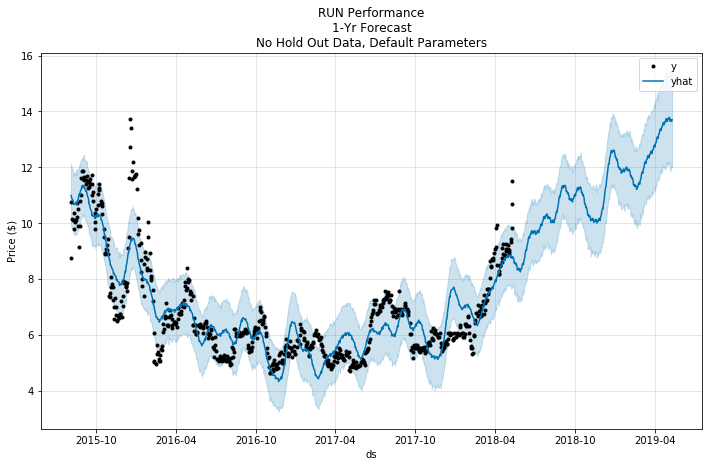

In [15]:
# Plot 
run_model.plot(run_forecast)
plt.title('RUN Performance\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

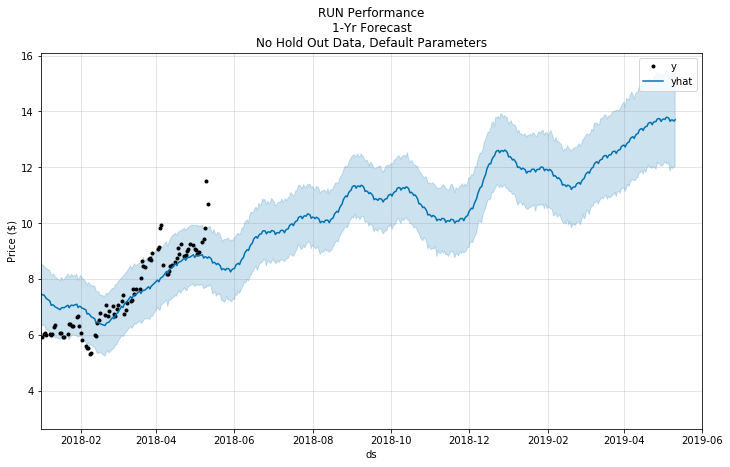

In [16]:
# Plot zoomed in to 2018
run_model.plot(run_forecast)
plt.title('RUN Performance\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Price ($)')
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2019, 6, 1)])
plt.legend()
plt.show()

Wow, Prophet certainly produces beautiful plots with a more realistic (though not necessarily accurate) looking forecast.  Using all available data, the price is expected to rise quite substantially, with a peak value near $14/share.  The observed data mostly falls with the 95% confidence intervals shown.

One of the input options we have is something called the changepoint sensitivity.  This adjusts model flexibility.  Smaller values make the model less flexible, while larger values make it more flexible.  Let's experiment with a range of values and see how the model changes.

C:\Users\mtracy\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


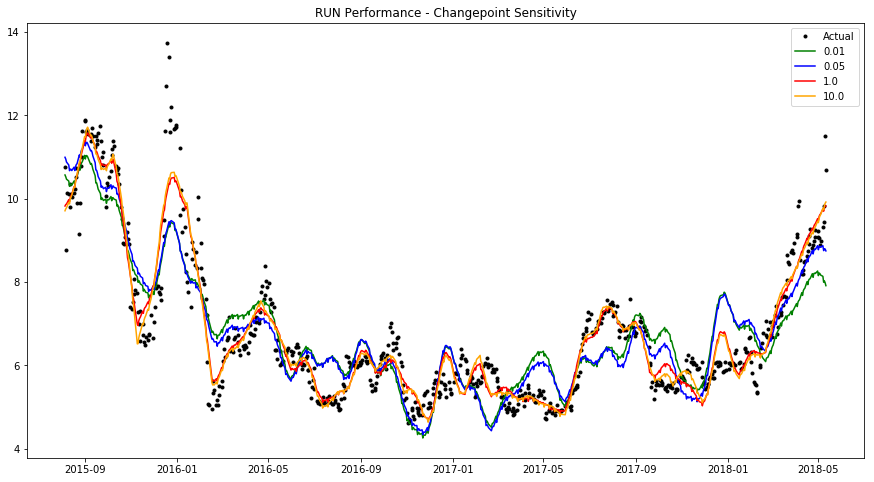

In [17]:
# Evaluate across range of changepoint sensitivity
changepoints = [0.01, 0.05, 1.0, 10.0]

for cp in changepoints:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=cp)
    model.fit(run_prophet)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    run_prophet[cp] = forecast['yhat']

# Plot results
plt.figure(figsize=(15,8))

# Acual observations
plt.plot(run_prophet['ds'], run_prophet['y'], '.', color='black', label='Actual')

# Different changepoints
colors = {0.01: 'g', 0.05: 'b', 1.0: 'r', 10.0: 'orange'}
for cp in changepoints:
    plt.plot(run_prophet['ds'], run_prophet[cp], color=colors[cp], label=cp)

plt.title('RUN Performance - Changepoint Sensitivity')
plt.legend()
plt.show()

We can see the changepoint setting makes a big difference in the model performance.  The two least flexible settings are mostly grouped together and don't show a whole lot difference between the two.  The same is true for the two most flexible settings. As expected, the more flexible models fit the highly variable time-series better.  Because there's not a huge observable difference between the 1.0 and 10 settings, we'll continue further analysis using a value of 1.0.

Prophet also allows the ability to decompose the data into different levels of seasonality/patterns.  We did this previously using Stats Models with little success, but for kicks, let's see how Prophet compares.

In [157]:
# Refit iwth changepoint value of 1.0
run_model = Prophet(daily_seasonality=False, changepoint_prior_scale=1.0)
run_model.fit(run_prophet[['ds', 'y']])
run_future = run_model.make_future_dataframe(periods=365)
run_forecast = run_model.predict(run_future)

RUN Decomposition


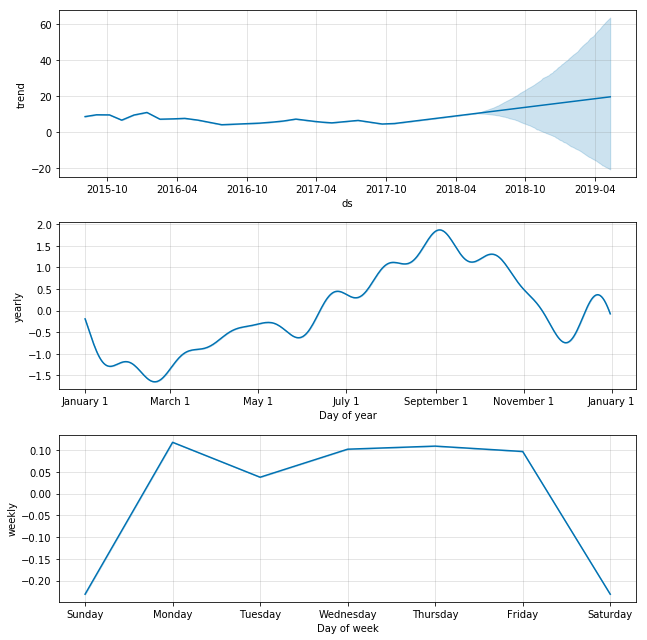

In [158]:
# Get decomposition components
print('RUN Decomposition')
run_model.plot_components(run_forecast)
plt.show()

Prophet picks up on an increasing trend, although the uncertainty is quite large.  Monthly seasonality is likely noise.  Looking at the time-series plot, we see September coincides with high, medium, and low price values across our time frame.  The model is also picking up a weekly trend with values being the lowest on the weekends.  Since there's no price data from weekends (markets are closed), this tells me the model is interpreting/imputing missing values.

Now let's validate the model using train/test data like we did with ARIMA. 

__Validate RUN Predictions__

In [18]:
# Validaate model predictions by splitting available data into train/test sets
# Take last 30 days as test data
train = df.run.dropna().reset_index()[:-30]
train = train.rename(columns={'date': 'ds', 'run': 'y'})

test = df.run.dropna().reset_index()[-30:]
test = test.rename(columns={'date': 'ds', 'run': 'y'})

train.head()

,ds,y
0,2015-08-05,10.77
1,2015-08-06,8.77
2,2015-08-07,10.14
3,2015-08-10,10.12
4,2015-08-11,9.79


In [19]:
# Fit model with training data, make 30 days of predictions 
train_model = Prophet(daily_seasonality=False, changepoint_prior_scale=1.0)
train_model.fit(train);
future = train_model.make_future_dataframe(periods=365)
forecast = train_model.predict(future)

C:\Users\mtracy\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


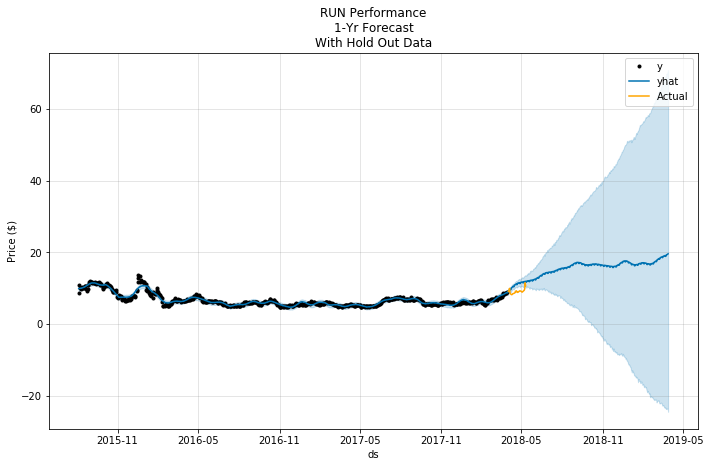

In [20]:
# Plot forecasted results based on training data.  Compare to actual.  

train_model.plot(forecast)
plt.plot(test['ds'], test['y'], label='Actual', color='orange')
plt.title('RUN Performance\n1-Yr Forecast\nWith Hold Out Data')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

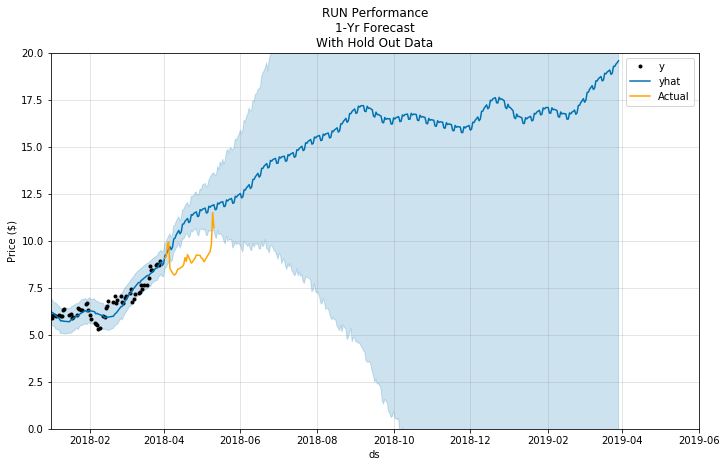

In [21]:
train_model.plot(forecast)
plt.plot(test['ds'], test['y'], label='Actual', color='orange')
plt.title('RUN Performance\n1-Yr Forecast\nWith Hold Out Data')
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2019, 6, 1)])
plt.ylim(0, 20)
plt.ylabel('Price ($)')
plt.legend()
plt.show()

MSE: 4.195944222154867


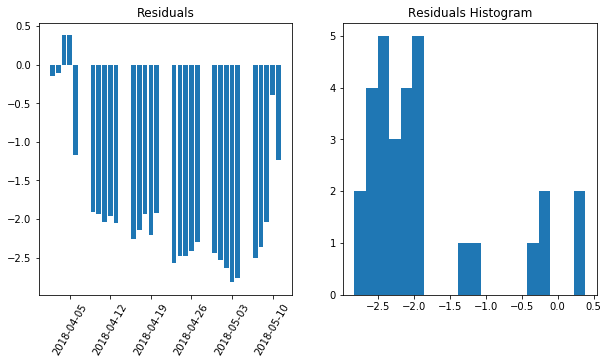

In [164]:
# Calculate MSE 
results = forecast[['ds', 'yhat']].merge(test, on='ds')
print('MSE:', mean_squared_error(results.y, results.yhat))

# Calculate residuals
results['residual'] = results['y'] - results['yhat']

# Plot results
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.bar(results.ds, results.residual)
plt.title('Residuals')
plt.xticks(rotation=60)

plt.subplot(122)
plt.hist(results.residual, bins=20)
plt.title('Residuals Histogram')

plt.show()

The MSE is 4.19, which is quite high.  The residuals also look pretty bad.  We see that the predictions replicate the weekly pattern of higher values Mon-Fri, and low values Sat/Sun.  However, the model consistently over predicts prices, and all but two of the predicted values are higher than the actual values.  The error term also grows with time as the model becomes more divergent from actual values and error is not normally distributed.

<a id='section19'></a>
### SPWR Models

Now let's try out Prophet on the SPWR data and see if it does any better. We'll again start by looking at the model with all available data provided as input.

__Forecast Entire Data Set - No Hold Out Validation__

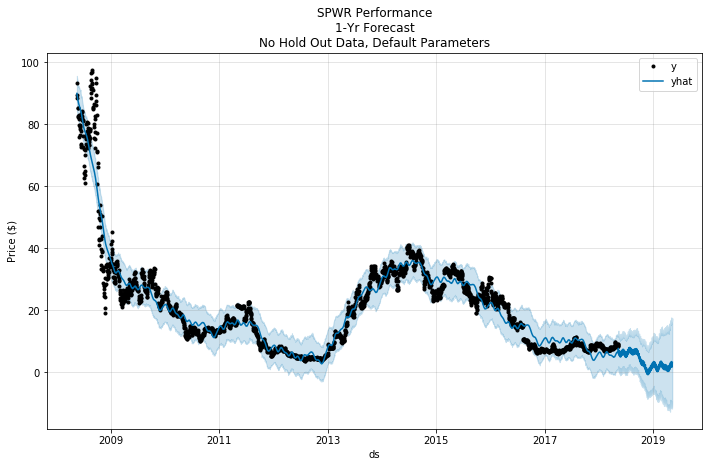

In [173]:
# Model with default parameters
spwr_model = Prophet(daily_seasonality=False)
spwr_model.fit(spwr_prophet)
spwr_future = spwr_model.make_future_dataframe(periods=365)
spwr_forecast = spwr_model.predict(spwr_future)

# Plot 
spwr_model.plot(spwr_forecast)
plt.title('SPWR Performance\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

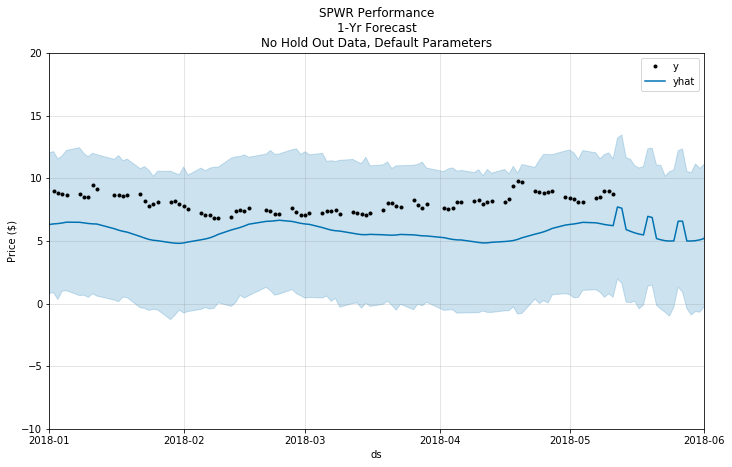

In [174]:
# Plot 
spwr_model.plot(spwr_forecast)
plt.title('SPWR Performance\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Price ($)')
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 6, 1)])
plt.ylim(-10, 20)
plt.legend()
plt.show()

Here, we see the model predicts lower than actual observations.  It's also picking up on some sort of weekly cycle.  We'll explore decompose shortly.  First, let's see how the different changepoint sensitivities fare on the SPWR data.

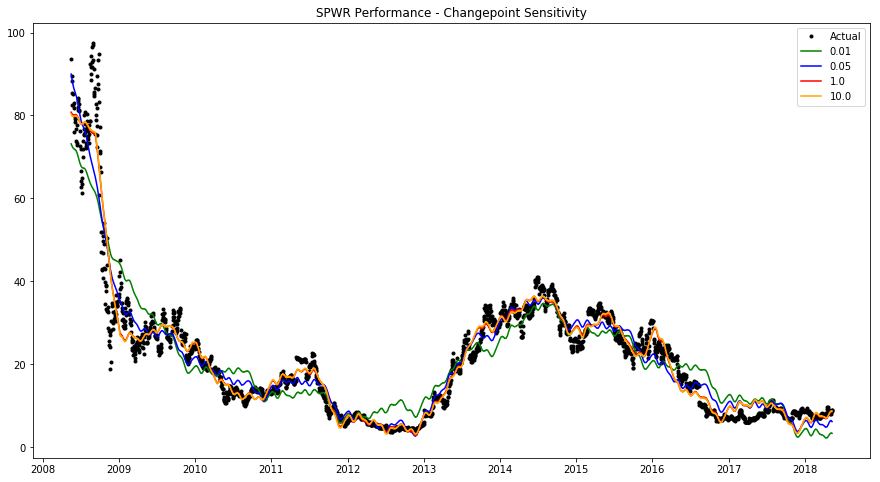

In [175]:
# Evaluate across range of changepoint sensitivity
changepoints = [0.01, 0.05, 1.0, 10.0]

for cp in changepoints:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=cp)
    model.fit(spwr_prophet)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    spwr_prophet[cp] = forecast['yhat']

# Plot results
plt.figure(figsize=(15,8))

# Acual observations
plt.plot(spwr_prophet['ds'], spwr_prophet['y'], '.', color='black', label='Actual')

# Different changepoints
colors = {0.01: 'g', 0.05: 'b', 1.0: 'r', 10.0: 'orange'}
for cp in changepoints:
    plt.plot(spwr_prophet['ds'], spwr_prophet[cp], color=colors[cp], label=cp)

plt.title('SPWR Performance - Changepoint Sensitivity')
plt.legend()
plt.show()

Again, the more flexible models fit the highly variable data better.  There isn't much of a difference between the two most flexible models, so we'll stick with 1.0 for further analysis.

Let's take a look at the decomposition.

In [49]:
# Refit with changepoint value of 1.0
spwr_model = Prophet(daily_seasonality=False, changepoint_prior_scale=1.0)
spwr_model.fit(spwr_prophet[['ds', 'y']])
spwr_future = spwr_model.make_future_dataframe(periods=365)
spwr_forecast = spwr_model.predict(spwr_future)

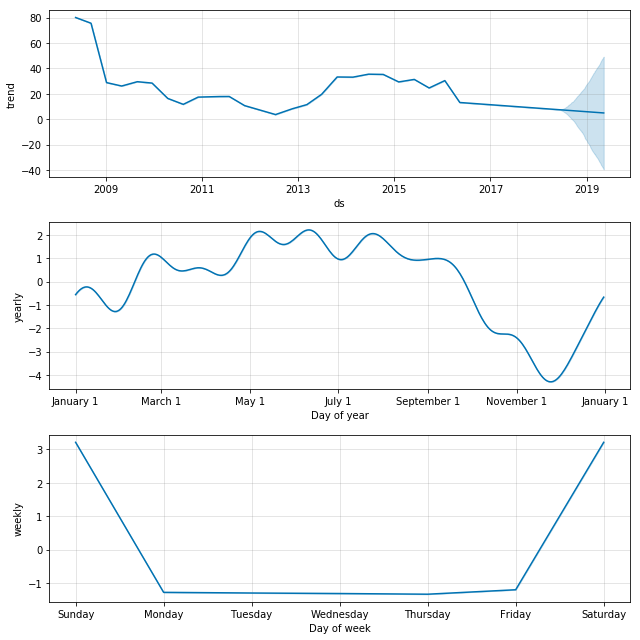

In [51]:
# Get decomposition components
spwr_model.plot_components(spwr_forecast)
plt.show()

Unlike RUN, Prophet picks up on an overall negative trend, again with much uncertainty.  Monthly seasonality appears to be random.  The weekly pattern is interesting, with trading days having lower values than the weekend.  There's not much information gain from SPWR decomposition.

Now let's find out the accuracy of the model using a test/train data set. 

__Validate SPWR Predictions__

In [176]:
# Validaate model predictions by splitting available data into train/test sets
# Take last 30 days as test data
train = df.spwr.reset_index()[:-30]
train = train.rename(columns={'date': 'ds', 'spwr': 'y'})

test = df.spwr.reset_index()[-30:]
test = test.rename(columns={'date': 'ds', 'spwr': 'y'})

train.head()

,ds,y
0,2008-05-16,93.50
1,2008-05-19,89.62
2,2008-05-20,88.37
3,2008-05-21,85.33
4,2008-05-22,82.64


In [177]:
# Fit model with training data, make 30 days of predictions 
train_model = Prophet(daily_seasonality=False, changepoint_prior_scale=1.0)
train_model.fit(train);
future = train_model.make_future_dataframe(periods=365)
forecast = train_model.predict(future)

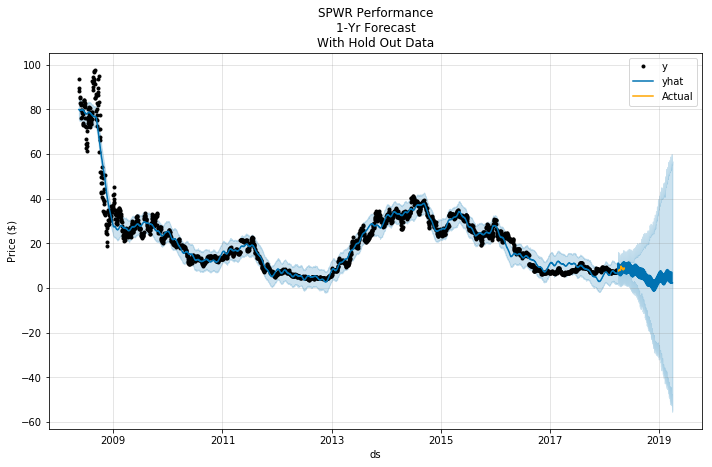

In [178]:
# Plot forecasted results based on training data.  Compare to actual. 

train_model.plot(forecast)
plt.plot(test['ds'], test['y'], label='Actual', color='orange')
plt.title('SPWR Performance\n1-Yr Forecast\nWith Hold Out Data')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

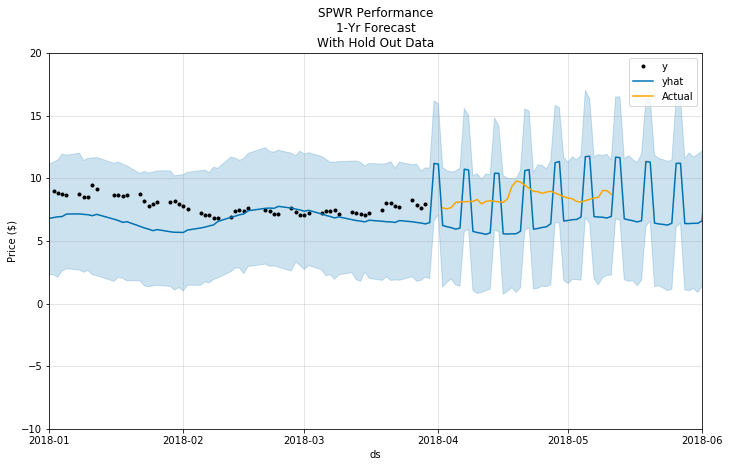

In [179]:
train_model.plot(forecast)
plt.plot(test['ds'], test['y'], label='Actual', color='orange')
plt.title('SPWR Performance\n1-Yr Forecast\nWith Hold Out Data')
plt.ylabel('Price ($)')
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 6, 1)])
plt.ylim(-10, 20)
plt.legend()
plt.show()

MSE: 5.949571624824352


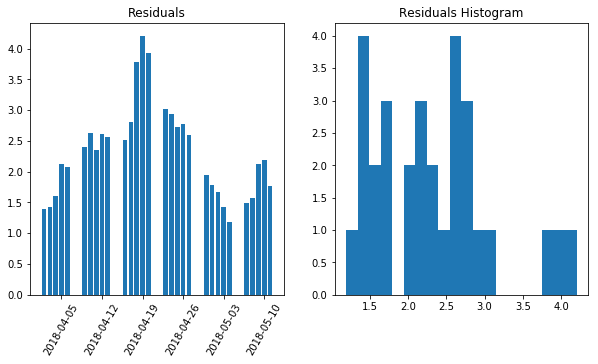

In [180]:
# Calculate MSE 
results = forecast[['ds', 'yhat']].merge(test, on='ds')
print('MSE:', mean_squared_error(results.y, results.yhat))

# Calculate residuals
results['residual'] = results['y'] - results['yhat']

# Plot results
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.bar(results.ds, results.residual)
plt.title('Residuals')
plt.xticks(rotation=60)

plt.subplot(122)
plt.hist(results.residual, bins=20)
plt.title('Residuals Histogram')

plt.show()

The MSE is 5.94, which is the highest of any model so far.  Predictions are grabbing ahold of weekly trends that aren't actually there.  With the exception of high values on the weekends, the model under predicts prices.  This is the opposite trend we saw with the RUN data.  

The residuals also look pretty bad.  The error term is somewhat more evenly distributed, but the error is still nowhere close to a normal distribution.

[return to top](#section1)

<a id='section23'></a>
## 10. Summary

We've covered a lot of ground in this notebook.  As a reminder, our orignial research question was the following: 

* __Can the stock price of each company be predicted with reasonable accuracy?  Based on what we learn, does investing in solar look promising?__

So, what did we learn about the future of our stocks and solar? 

Well, it depends on what model you ask and what data you feed it, but generally speaking, not a whole lot.  We looked at a large range of ARIMA configurations as well as a more powerful forecasting tool developed by the research folks over at Facebook.  Overall, none of the models performed particularly well at forecasting stock prices.  This speaks more to the lack of structure in stock data rather than inadequacies of the models themselves.  Turns out it's really hard to predict future stock prices based on past price performance alone (who would have though?!). In hindsight, this makes complete sense.   

The biggest takeaway is that forecasting data with no real pattern or structure to it is guess work at best.  Predictions should be met with great skepticism and caution due to the large degree of uncertainty.  

I'm not giving up on the solar or renewable energy markets for reasons that extend beyond investing goals.  But for the moment, I will be keeping my money in a totally boring index fund.  

Thanks for reading!

[return to top](#section1)